In [1]:
# THIS IS JUST THE PARAMETER INFERENCE TUTORIAL I USED FOR DEBUGGING
# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import jax.random as jr
import jax.numpy as np
import dLux as dl
import dLux.utils as dlu
import matplotlib.pyplot as plt

# Set global plotting parameters
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

In [2]:
from dLuxToliman import AlphaCen

# Use the AlphaCen object for separation in units of arcseconds, and flux in log
source = AlphaCen()
source = source.set(['log_flux', 'separation'], [3.5, 0.1])

# Aperture properties
wf_npix = 128
diameter = 1

# Construct an aperture with a single spider as the asymmetry
coords = dlu.pixel_coords(5*wf_npix, diameter)
circle = dlu.circle(coords, diameter/2)
transmission = dlu.combine([circle], 5)

# Zernike aberrations
zernike_indexes = np.arange(4, 11)
true_coeffs = 1e-9 * jr.normal(jr.PRNGKey(0), zernike_indexes.shape)
coords = dlu.pixel_coords(wf_npix, diameter)
basis = np.array([dlu.zernike(i, coords, diameter) for i in zernike_indexes])

layers = [('aperture', dl.layers.BasisOptic(basis, transmission, true_coeffs, normalise=True))]

# Psf properties
psf_npixels = 16
psf_pixel_scale = 0.03

# Construct
optics = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npixels, psf_pixel_scale)

# Construct Telescope
telescope = dl.Telescope(optics, ('source', source))

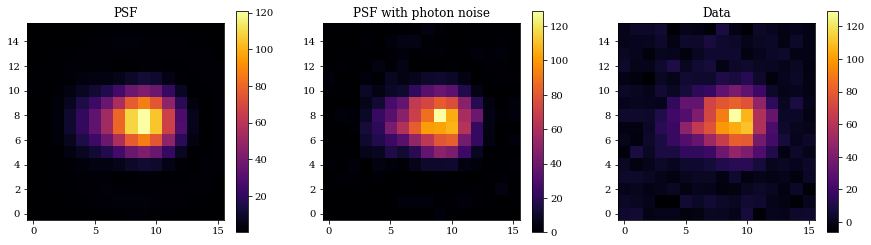

In [3]:
## Generate psf
psf = telescope.model()
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 3*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data = psf_photon + bg_noise

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("PSF with photon noise")
plt.imshow(psf_photon)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Data")
plt.imshow(data)
plt.colorbar()
plt.show()

In [14]:
# just gonna force my stuff in here:
# making the cramer rao lower bound plots
# essentially, how well you can constrain the position of something is given by how much its gradient changes
# first, we need to generate airy disc and toliman psfs. 

# but before that, get our imports done
import dLux as dl
import dLuxToliman as dlT
# gonna use normal numpy. jax numpy is weird.
import numpy as np
from matplotlib import pyplot as plt
import dLux.utils as dlu
import jax
import jax.random as jr

# let's create the toliman pupil and obstructions, call it tolOptics

# might as well use 1024 pixels wavefront. nice and large number
wf_npixels = 128

# same for psf
psf_npixels = 64

# no need for oversampling
oversample = 1 # don't change

# toliman pixel scale
psf_pixel_scale = 0.375

tolOptics = dlT.TolimanOpticalSystem(wf_npixels, psf_npixels, oversample, psf_pixel_scale)

# now let's extract the pupil
tolPupil = tolOptics.pupil.opd

# make it a nice phase difference instead of OPD
tolPupilPhase = dlu.opd2phase(tolPupil, 585e-9) # it is pi phase difference for 585e-9 wavelength

# layer
tolPupilLayer = dl.layers.AberratedLayer(phase=tolPupilPhase)

# (normal toliman diameter)
diameter = 0.125

# initialsing coords for circular aperture
coords = dlu.pixel_coords(wf_npixels,diameter)

# x = np.arange(wf_npixels)
# y = np.arange(wf_npixels)
# X, Y = np.meshgrid(x,y, indexing = 'ij') # I believe the indexing part is neccessary? Anyway doesn't break anything

# creating the aperture (circular)
airyAperture = dlu.circle(coords,0.5 * diameter)

# making it a layer
airyApertureLayer = dl.layers.TransmissiveLayer(transmission=airyAperture, normalise=True)

# making the optical systems
tolPupilLayers = [
    (
        'aperture',
        airyApertureLayer
    ),
    (
        'pupil',
        tolPupilLayer
    )
]

airyApertureLayers = [
    (
        'aperture',
        airyApertureLayer
    )
]

tolPupilSystem = dl.AngularOpticalSystem(wf_npixels, diameter, tolPupilLayers, psf_npixels, psf_pixel_scale, oversample)

airyApertureSystem = dl.AngularOpticalSystem(wf_npixels, diameter, airyApertureLayers, psf_npixels, psf_pixel_scale, oversample)

# main stuff
# now... generate a lot of them for many photon counts and get some numbers
fluxes = np.logspace(3,9,7)

# just monochromatic
wavelengths = np.linspace(585e-9,585e-9,1)
# monochromatic
weights = np.linspace(1,1,1)

# at 0,0
position = dlu.arcsec2rad(np.array([0,0]))

x_pos = 0
y_pos = 0

airyCramer = np.zeros_like(fluxes)
tolCramer = np.zeros_like(fluxes)

# for photon noise
total_samples = 20

# setting up noise psfs
airyPsfNoise = np.zeros((fluxes.shape[0], total_samples, psf_npixels, psf_npixels))
tolPsfNoise = np.zeros((fluxes.shape[0], total_samples, psf_npixels, psf_npixels))

# many photons
for i, flux in enumerate(fluxes):
    # source
    # source = dl.PointSource(wavelengths, position, flux, weights)

    source = dlT.AlphaCen(x_position=x_pos,y_position=y_pos,log_flux=np.log10(flux))

    airyPsf = airyApertureSystem.model(source)

    tolPsf = tolPupilSystem.model(source)

    # need to now make functions calculating the gradient
    # do we need pixel scale?

    # initialising derivative array
    airyPsfDx = np.zeros_like(airyPsf)

    # first column (forward difference)
    airyPsfDx[:, 0] = airyPsf[:, 1] - airyPsf[:, 0]

    # middle columns (middle difference)
    airyPsfDx[:, 1:-1] = (airyPsf[:, 2:] - airyPsf[:, :-2])/2

    # final column (backwards difference)
    airyPsfDx[:, -1] = airyPsf[:, -1] - airyPsf[:, -2]

    # now for toliman
    # initialising derivative array
    tolPsfDx = np.zeros_like(tolPsf)

    # first column (forward difference)
    tolPsfDx[:, 0] = tolPsf[:, 1] - tolPsf[:, 0]

    # middle columns (middle difference)
    tolPsfDx[:, 1:-1] = (tolPsf[:, 2:] - tolPsf[:, :-2])/2

    # final column (backwards difference)
    tolPsfDx[:, -1] = tolPsf[:, -1] - tolPsf[:, -2]

    airyInverseDiffSquare = np.sum(airyPsfDx**2/airyPsf)
    tolInverseDiffSquare = np.sum(tolPsfDx**2/tolPsf)

    airyCramer[i] = psf_pixel_scale*1/np.sqrt(airyInverseDiffSquare)
    tolCramer[i] = psf_pixel_scale*1/np.sqrt(tolInverseDiffSquare)

    # now let's do it for some random samples from poisson distribution
    
    samples = np.arange(0,total_samples,1)

    for sample in samples:

        airyPsfNoise[i, sample] = jr.poisson(jr.PRNGKey(sample),airyPsf) 
        tolPsfNoise[i, sample] = jr.poisson(jr.PRNGKey(sample),tolPsf) 

In [17]:
# define telescopes
source = dlT.AlphaCen(x_position=0,y_position=0,log_flux=np.log10(fluxes[2]))
airyTelescope = dl.Telescope(airyApertureSystem, ('source', source))
tolTelescope = dl.Telescope(tolPupilSystem, ('source', source))

In [18]:
# PPL
import numpyro as npy
import numpyro.distributions as dist

parameters = ['x_position']

def psf_model(data, model):
    """
    Define the numpyro function
    """
    values = [
        npy.sample("x",        dist.Uniform(-0.1, 0.1)),
    ]

    with npy.plate("data", len(data.flatten())):
        poisson_model = dist.Poisson(
            model.set(parameters, values).model().flatten())
        return npy.sample("psf", poisson_model, obs=data.flatten())

In [19]:
data = airyPsfNoise[2,0]
telescope = airyTelescope

In [20]:
from jax import device_count
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=2000,
    num_samples=2000,
    num_chains=device_count(),
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data, telescope)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 2.13 s, sys: 84.8 ms, total: 2.22 s
Wall time: 1.22 s


In [21]:
print(telescope)

Telescope(
  optics=AngularOpticalSystem(
    wf_npixels=128,
    diameter=0.125,
    layers={
      'aperture':
      TransmissiveLayer(transmission=f32[128,128], normalise=True)
    },
    psf_npixels=64,
    oversample=1,
    psf_pixel_scale=0.375
  ),
  source=AlphaCen(
    separation=10.0,
    position_angle=90,
    x_position=0,
    y_position=0,
    log_flux=np.float64(5.0),
    contrast=3.37,
    bandpass=(530, 640),
    weights=f32[2,3],
    wavelengths=f32[3]
  ),
  detector=None
)


In [22]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.00      0.00      0.00     -0.00      0.00   2771.97      1.00

Number of divergences: 0
